In [49]:
import os
import json
from PIL import Image
import numpy as np
import torchvision
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes
import math
import matplotlib.pyplot as plt


In [50]:
#インデックスを物体名に変換
index2name = [
    'pedestrian',
    'rider',
    'car',
    'truck',
    'bus',
    'train',
    'motorcycle',
    'bicycle',
    'traffic light',
    'traffic sign',
]
print(index2name)

# 物体名をインデックスに変換
name2index = {}
for i in range(len(index2name)):
    name2index[index2name[i]] = i
print(name2index)
# print(name2index["pedestrian"])

['pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']
{'pedestrian': 0, 'rider': 1, 'car': 2, 'truck': 3, 'bus': 4, 'train': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic light': 8, 'traffic sign': 9}


In [51]:
class BDDDataset(Dataset):
    def __init__(self, img_dir, json_file, transform=None, limit=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(json_file) as f:
            self.data = json.load(f)
        if limit:
            self.data = self.data[:limit]  # 最初の`limit`枚にデータを制限
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data[idx]['name'])
        image = Image.open(img_path).convert("RGB")
        
        # 必要に応じてアノテーションデータを処理
        boxes = []
        labels = []
        # 'labels'キーが存在するかチェック
        if 'labels' in self.data[idx]:
            for label in self.data[idx]['labels']:
                if label['category'] != 'traffic light' and label['category'] != 'traffic sign':  # 例として車と歩行者を対象にする
                    if label['category'] in index2name:
                        x1, y1 = label['box2d']['x1'], label['box2d']['y1']
                        x2, y2 = label['box2d']['x2'], label['box2d']['y2']
                        boxes.append([x1, y1, x2, y2])
                        labels.append(name2index[label['category']])
        # アノテーションが空の場合、空のターゲットを返さないようにする
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self.data))  # 次のサンプルを返すか、データローダーに問題がある場合は例外処理を行う
        
        if self.transform:
            image = self.transform(image)
        
        target = {
            'boxes': torch.tensor(boxes),
            'labels': torch.tensor(labels)
        }
        
        return image, target

# 使用するデータ変換
transform = transforms.Compose([
    # transforms.Resize((640, 360)),
    transforms.ToTensor()
])

# データローダーの作成
dataset_train = BDDDataset('/Volumes/volume/BDD100K/bdd100k/images/100k/train', '/Volumes/volume/BDD100K/bdd100k/labels/det_20/det_train.json', transform=transform, limit=100)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0)

dataset_val = BDDDataset('/Volumes/volume/BDD100K/bdd100k/images/100k/val', '/Volumes/volume/BDD100K/bdd100k/labels/det_20/det_val.json', transform=transform, limit=20)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=0)


# Confirm dataset

{'boxes': tensor([[[ 562.3438,  311.5550,  577.7928,  325.7166],
         [ 572.6431,  316.7046,  613.8405,  342.4530],
         [ 593.2418,  314.1298,  688.0187,  377.2132],
         [ 422.0153,  314.1298,  460.6378,  338.5907],
         [ 280.8884,  316.8673,  356.3571,  364.3391],
         [ 685.9359,  311.5550,  737.4326,  348.8900],
         [ 697.5226,  321.8543,  737.4326,  368.2013],
         [ 734.8577,  290.9563,  872.1215,  377.2132],
         [ 795.3663,  311.5550,  948.5690,  409.3987],
         [ 939.5570,  208.5616, 1279.3562,  546.0746],
         [ 956.2935,  294.8185,  974.3173,  334.7285],
         [ 222.4657,  306.4053,  245.6392,  356.6146]]]), 'labels': tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]])}


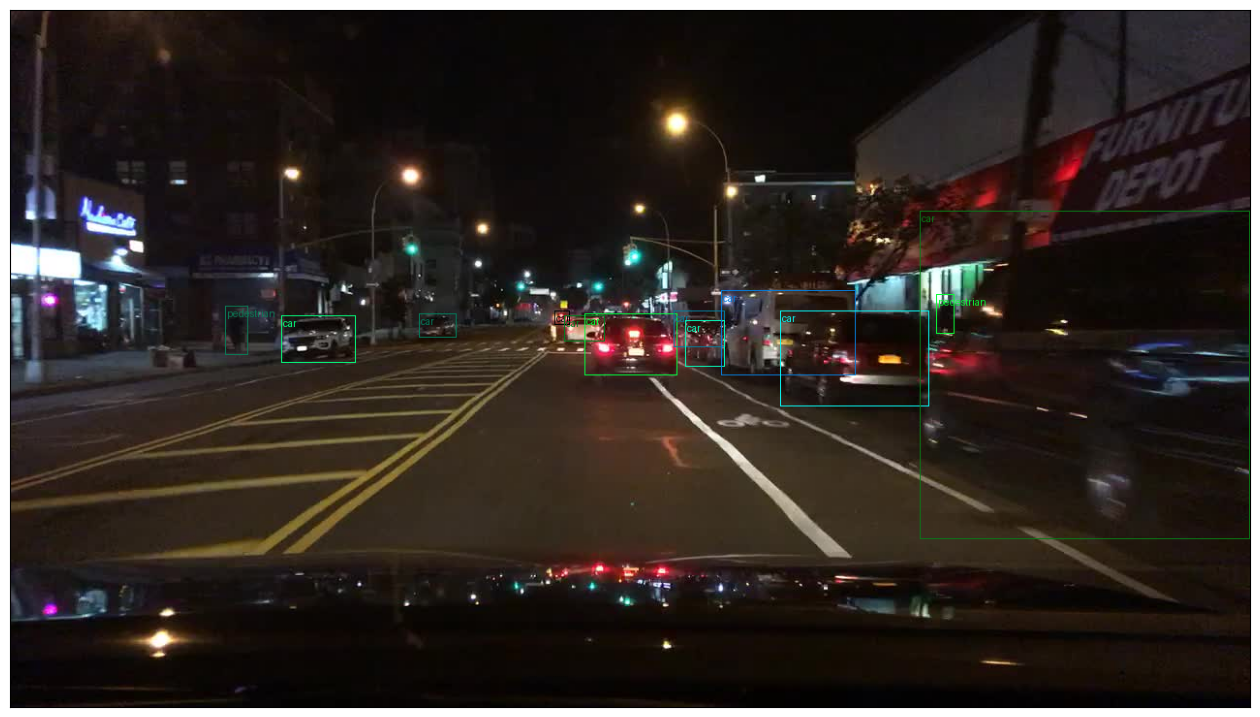

In [52]:
def show_boxes(image, boxes, names):
    drawn_boxes = draw_bounding_boxes(image, boxes, labels=names)

    plt.figure(figsize = (16,16))
    plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))  # チャンネルを一番後ろに
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
    plt.savefig("output.png")
    plt.show()
    

dataiter = iter(dataloader_train)  # イテレータ
image, target = next(dataiter)  # バッチを取り出す
print(target)

image = image[0]
image = (image*255).to(torch.uint8)  # draw_bounding_boxes関数の入力は0-255

boxes = target["boxes"][0]

labels = target["labels"][0]
names = [index2name[label.item()] for label in labels]

show_boxes(image, boxes, names)

In [53]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

num_classes=len(index2name)+1  # 分類数: 背景も含めて分類するため1を加える
num_anchors = model.head.classification_head.num_anchors  # アンカーの数

# 分類数を設定
model.head.classification_head.num_classes = num_classes

# 分類結果を出力する層の入れ替え
cls_logits = torch.nn.Conv2d(256, num_anchors*num_classes, kernel_size=3, stride=1, padding=1)
torch.nn.init.normal_(cls_logits.weight, std=0.01)  # RetinaNetClassificationHeadクラスより
torch.nn.init.constant_(cls_logits.bias, -math.log((1 - 0.01) / 0.01))  # RetinaNetClassificationHeadクラスより
model.head.classification_head.cls_logits = cls_logits  # 層の入れ替え

# 全てのパラメータを更新不可に
for p in model.parameters():
    p.requires_grad = False

# classification_headのみパラメータを更新可能に
for p in model.head.classification_head.parameters():
    p.requires_grad = True

# model.cuda()  # GPU対応

In [56]:
# 最適化アルゴリズム
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
device = torch.device("mps") if torch.has_mps else torch.device("cpu")
model.train()  # 訓練モード
model = model.to(device)  # モデルをデバイスに移動
epochs = 10
patience = 2  # 早期停止のためのパラメータ
best_val_loss = float("inf")
epochs_without_improvement = 0
# 訓練ループ
for epoch in range(epochs):
    for i, (image, target) in enumerate(dataloader_train):
        try:
            image = image.to(device)  # 画像をデバイスに移動

            boxes = target["boxes"][0].to(device)
            labels = target["labels"][0].to(device)
            target = [{"boxes": boxes, "labels": labels}]  # ターゲットは辞書を要素に持つリスト
            # print("boxes shape:", boxes.shape)  # デバッグ用に形状を出力
            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())  # 誤差の合計を計算

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:  # 100回ごとに経過を表示
                print("epoch:", epoch, "iteration:", i, "loss:", loss.item())
        except Exception as e:
            print(f"An error occurred at epoch {epoch}, iteration {i}: {e}")
            continue  # エラー発生時にこのイテレーションをスキップ

    # 検証ループ
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, target in dataloader_val:
            image = image.to(device)
            boxes = target["boxes"][0].to(device)
            labels = target["labels"][0].to(device)
            target = [{"boxes": boxes, "labels": labels}]
            
            loss_dic = model(image, target)
            loss = sum(loss for loss in loss_dic.values())
            val_loss += loss.item()
    
    val_loss /= len(dataloader_val)
    print(f"Epoch {epoch} - Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # モデルの保存
        PATH = './retinanet.pth'
        torch.save(model.state_dict(), PATH)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

/var/folders/93/lzkt4bt950x74g63m9sjk_br0000gn/T/ipykernel_33841/3862116222.py:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps") if torch.has_mps else torch.device("cpu")


[{'boxes': tensor([[ 610.6898,  283.8131,  903.3001,  505.1883],
        [ 334.6463,  270.9491,  514.3947,  424.2084],
        [ 476.9069,  279.5371,  558.6683,  378.6912],
        ...,
        [ 453.6502,    0.0000, 1247.3018,  357.6321],
        [ 643.6057,  170.9702,  952.9462,  617.5929],
        [ 172.3689,  364.1237, 1140.7230,  615.6239]], device='mps:0'), 'scores': tensor([0.9837, 0.9543, 0.8809, 0.7953, 0.7871, 0.5963, 0.5948, 0.5328, 0.5176,
        0.4739, 0.4333, 0.3918, 0.3603, 0.3394, 0.3355, 0.3321, 0.3218, 0.3158,
        0.3089, 0.2972, 0.2910, 0.2867, 0.2698, 0.2690, 0.2644, 0.2615, 0.2613,
        0.2607, 0.2559, 0.2535, 0.2516, 0.2511, 0.2475, 0.2437, 0.2412, 0.2404,
        0.2362, 0.2324, 0.2249, 0.2245, 0.2226, 0.2218, 0.2208, 0.2197, 0.2192,
        0.2191, 0.2164, 0.2146, 0.2095, 0.2048, 0.2038, 0.2018, 0.2005, 0.1987,
        0.1971, 0.1965, 0.1944, 0.1931, 0.1904, 0.1897, 0.1887, 0.1870, 0.1855,
        0.1831, 0.1818, 0.1802, 0.1801, 0.1796, 0.1761, 0.1756, 

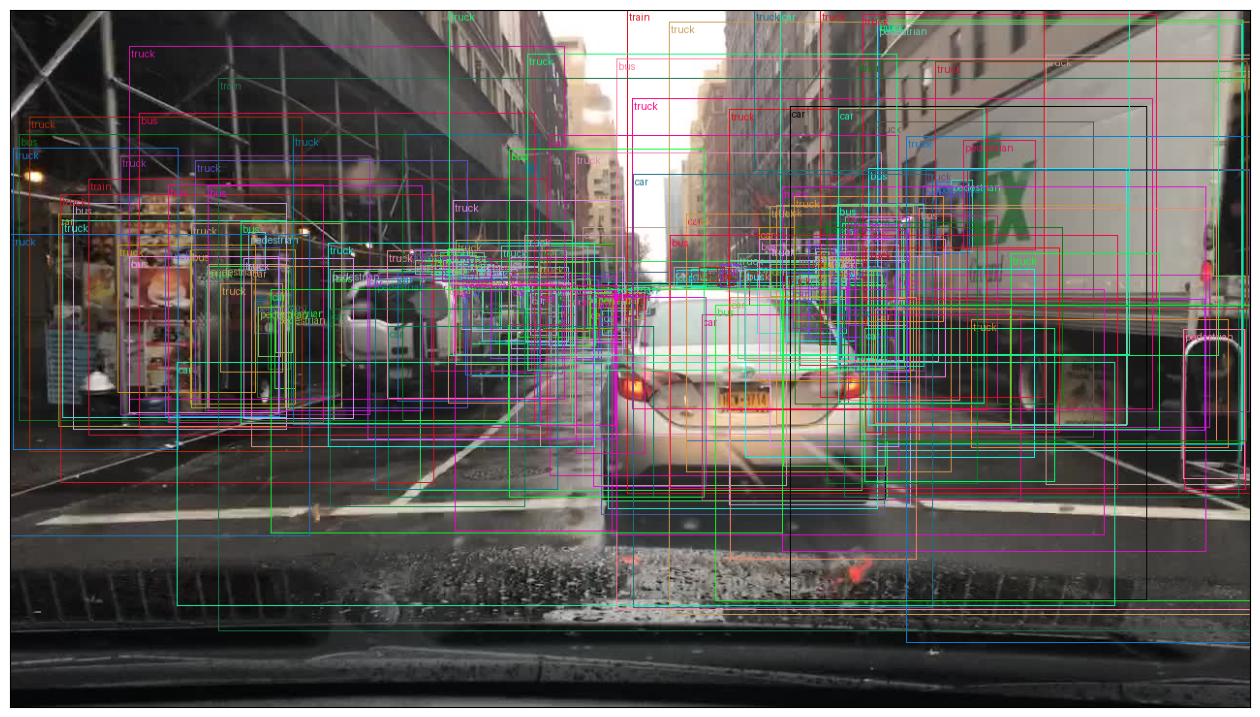

In [15]:
dataiter = iter(dataloader_val)  # イテレータ
image, target = next(dataiter)  # バッチを取り出す

image = image.to(device)  # 画像をデバイスに移動

model.eval()
predictions = model(image)
print(predictions)

image = (image[0]*255).to(torch.uint8).cpu() # draw_bounding_boxes関数の入力は0-255
boxes = predictions[0]["boxes"].cpu()
labels = predictions[0]["labels"].cpu().detach().numpy()
labels = np.where(labels>=len(index2name), 0, labels)  # ラベルが範囲外の場合は0に
names = [index2name[label.item()] for label in labels]

print(names)
show_boxes(image, boxes, names)

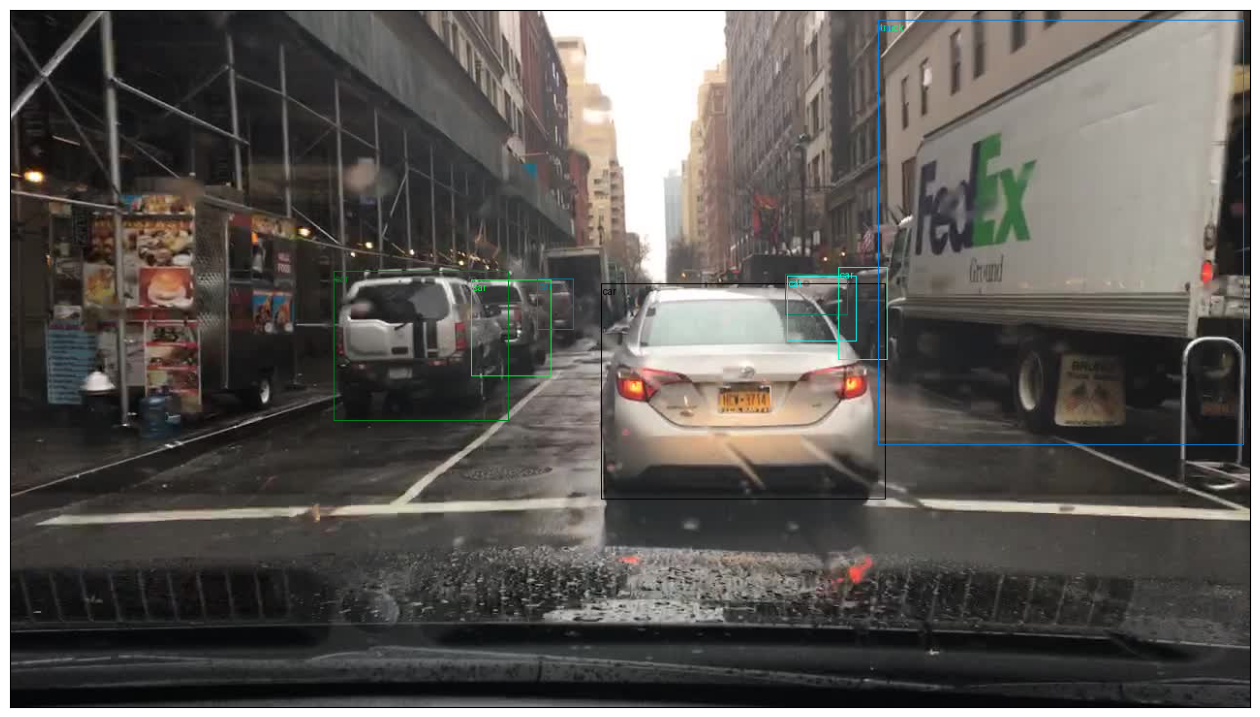

In [16]:
boxes = []
names = []
for i, box in enumerate(predictions[0]["boxes"]):
    score = predictions[0]["scores"][i].cpu().detach().numpy()
    if score > 0.5:  # スコアが0.5より大きいものを抜き出す
        boxes.append(box.cpu().tolist())
        label = predictions[0]["labels"][i].item()
        if label >= len(index2name):  # ラベルが範囲外の場合は0に
            label = 0
        name = index2name[label]
        names.append(name)
boxes = torch.tensor(boxes)

show_boxes(image, boxes, names)